In [253]:
import pandas as pd
import numpy as np

from statsmodels.discrete.discrete_model import Logit
# And some functions we will need
from scipy.special import logit
import matplotlib.pyplot as plt
# start by bringing in the dataset

df = pd.read_pickle("../data/set_df.pkl") 

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7257 entries, 11 to 166605
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   set_id                7257 non-null   int64         
 1   latitude              7257 non-null   float64       
 2   longitude             7257 non-null   float64       
 3   dt                    7257 non-null   datetime64[ns]
 4   elevation             7257 non-null   int64         
 5   American plaice       7257 non-null   bool          
 6   Atlantic cod          7257 non-null   bool          
 7   Atlantic herring      7257 non-null   bool          
 8   Redfish unidentified  7257 non-null   bool          
 9   American lobster      7257 non-null   bool          
 10  Snow crab             7257 non-null   bool          
dtypes: bool(6), datetime64[ns](1), float64(2), int64(2)
memory usage: 382.7 KB


In [255]:
# we'll start with redfish since they should be an easy one to predict
species = 'Snow crab'
# species = 'Redfish unidentified'
# species = 'American lobster'
# species = 'American plaice'
# species = 'Atlantic cod'
# species = 'Atlantic herring'

predictors = ['latitude', 'longitude', 'elevation']
m = Logit(df[species], df[predictors])
m = m.fit()

Optimization terminated successfully.
         Current function value: 0.621462
         Iterations 5


In [256]:
m.params


latitude     0.509457
longitude    0.374551
elevation    0.000135
dtype: float64

In [257]:
print(m.summary2())


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Snow crab        Pseudo R-squared: 0.045     
Date:               2024-04-12 22:06 AIC:              9025.9000 
No. Observations:   7257             BIC:              9046.5692 
Df Model:           2                Log-Likelihood:   -4510.0   
Df Residuals:       7254             LL-Null:          -4721.6   
Converged:          1.0000           LLR p-value:      1.1625e-92
No. Iterations:     5.0000           Scale:            1.0000    
-------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
-------------------------------------------------------------------
latitude    0.5095     0.0314   16.2425   0.0000    0.4480   0.5709
longitude   0.3746     0.0233   16.0904   0.0000    0.3289   0.4202
elevation   0.0001     0.0005    0.2757   0.7828   -0.0008   0.0011


In [258]:
df.loc[:, 'p'] = m.predict(df[predictors])

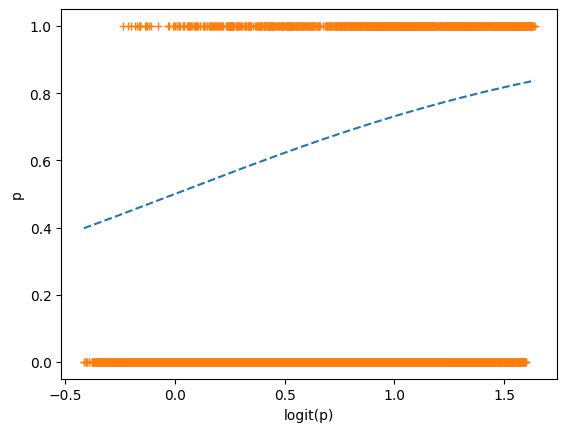

In [259]:
df = df.sort_values(by = ['p'], axis = 0)
plt.plot(logit(df.p), df.p, '--')
plt.plot(logit(df.p), df["Redfish unidentified"], '+')
plt.xlabel('logit(p)')
plt.ylabel('p')
plt.show()

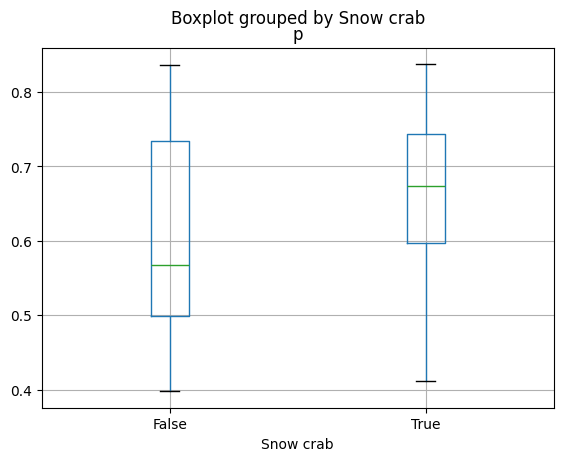

In [260]:
df.boxplot(column='p', by = species)
plt.show()

In [261]:
df.loc[:, 'yhat'] = (df.p > 0.5) * 1
df.yhat.value_counts()

1    6395
0     862
Name: yhat, dtype: int64

In [262]:
pd.crosstab(df["Redfish unidentified"], df.yhat)


yhat,0,1
Redfish unidentified,,
False,842,4776
True,20,1619


In [263]:
conf_mat = m.pred_table()
conf_mat

array([[ 650., 1928.],
       [ 212., 4467.]])

In [264]:
tn, fp, fn, tp = conf_mat.flatten()
print (tn, fp, fn, tp)

650.0 1928.0 212.0 4467.0


In [265]:
acc = (tp + tn) / np.sum(conf_mat)
print ("Accuraccy of the model is: %1.2f" % acc)

Accuraccy of the model is: 0.71


In [266]:
mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
print ("Mathews correlation coefficient between the estimates and the true response is: %1.2f" % mcc)

Mathews correlation coefficient between the estimates and the true response is: 0.31


In [267]:
prc = tp / (tp + fp)
rec = tp / (tp + fn)
print ("Model's precision is %1.2f and it's recall is %1.2f" % (prc, rec))

Model's precision is 0.70 and it's recall is 0.95


In [268]:
# Set discrimination thresholds
ths = np.arange(0., 1.0, 0.025)

# Containers
sensitivity = []
specificity = []
accuracy = []
matthews = []

# Main loop
for th in ths:
    # Generate estimates
    conf_mat = m.pred_table(threshold=th)
    
    # Extract TN, FP, ...
    tn, fp, fn, tp = conf_mat.flatten()
    
    # Calculate sensitivity and specificity
    sens = (1. * tp) / (tp + fn)
    spec = (1. * tn) / (tn + fp)    
    
    # Calculate ACC and MCC
    acc = (tp + tn) / np.sum(conf_mat)
    mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))    

    # Add to containers
    sensitivity.append(sens)
    specificity.append(spec)
    accuracy.append(acc)
    matthews.append(mcc)

/tmp/ipykernel_11899/59817041.py:24: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))


In [269]:
# Bind all the numbers together
roc = pd.DataFrame({'discret_thr' : ths, 
                    'sensitivity' : sensitivity, 
                    'specificity' : specificity,
                    '_specificity' : [1 - x for x in specificity],
                    'accuracy' : accuracy, 
                    'matthews' : matthews})

# Sort by 1 - specificity so we can plot it easily
roc = roc.sort_values(by = "_specificity")

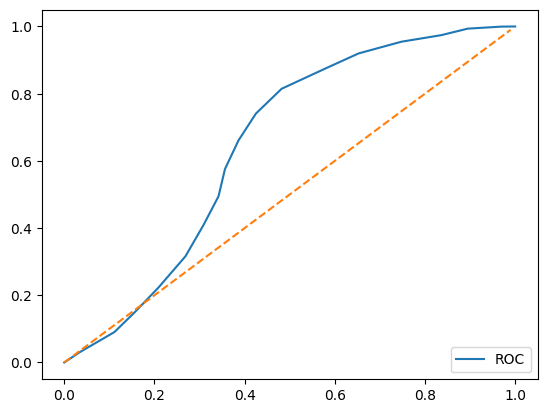

In [270]:
plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')
plt.plot(np.arange(0., 1., 0.01), 
         np.arange(0., 1., 0.01), 
         '--')

plt.legend(loc = 4)

In [271]:
auc = np.trapz(y = roc.sensitivity, x = roc._specificity)
print ("Area under ROC curve = %1.2f" % auc)


Area under ROC curve = 0.65


In [272]:
# Where threshold equal 0.5
idx_default_th = np.where(roc.discret_thr == 0.5)[0][0]

# Max sum of spec and sens
idx_youdensj = np.argmax(roc.sensitivity + roc.specificity)

 # Balanced spec and sens
idx_ballance = np.argmin(np.abs(roc.sensitivity - roc.specificity))

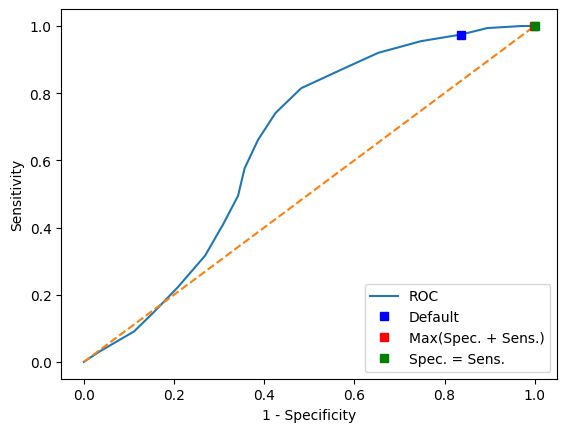

In [273]:
plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')

plt.plot(np.arange(0., 1., 0.01), 
         np.arange(0., 1., 0.01), 
         '--')

plt.plot(roc._specificity[idx_default_th], 
         roc.sensitivity[idx_default_th], 
         's', color = 'blue',
         label = 'Default')

plt.plot(roc._specificity[idx_youdensj], 
         roc.sensitivity[idx_youdensj], 
         's', color = 'red',
         label = 'Max(Spec. + Sens.)')

plt.plot(roc._specificity[idx_ballance], 
         roc.sensitivity[idx_ballance], 
         's', color = 'green', 
         label = 'Spec. = Sens.')


plt.legend(loc = 4)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()


In [274]:
m.pred_table(threshold=roc.discret_thr[idx_youdensj])


array([[2.000e+00, 2.576e+03],
       [0.000e+00, 4.679e+03]])

In [275]:
m.pred_table(threshold=roc.discret_thr[idx_ballance])


array([[   0., 2578.],
       [   0., 4679.]])

In [276]:
J = max(roc.sensitivity + roc.specificity - 1)
print ('Youden\'s J = %1.2f' % J)

Youden's J = 0.33


In [277]:
print ('Odds mean: %1.2f' % np.mean(df['p']))
print ('Response mean: %1.2f' % np.mean(df[species]))

Odds mean: 0.65
Response mean: 0.64


In [278]:
print ('Predicted positives #: %i' % np.sum(df['p'] > 0.5))
print ('True positives #: %i' % np.sum(df[species] > 0.5))

Predicted positives #: 6395
True positives #: 4679


In [279]:
print (conf_mat)

[[2578.    0.]
 [4679.    0.]]


In [280]:
# Predicted negatives and positives
conf_mat.sum(axis = 0)

array([7257.,    0.])

In [281]:
# Actual negatives and positives
conf_mat.sum(axis = 1)

array([2578., 4679.])

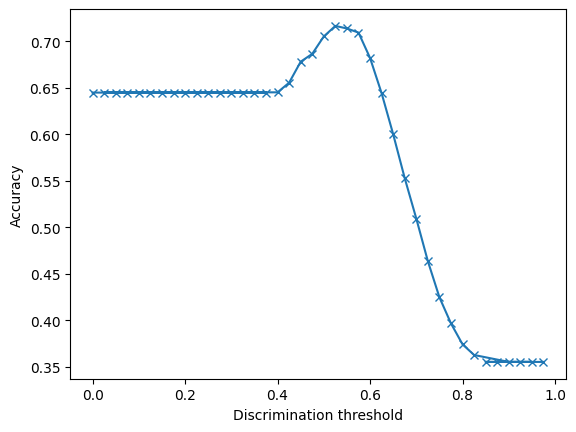

In [282]:
plt.plot(roc.discret_thr, roc.accuracy, 'x-')
plt.xlabel('Discrimination threshold')
plt.ylabel('Accuracy')
plt.show()

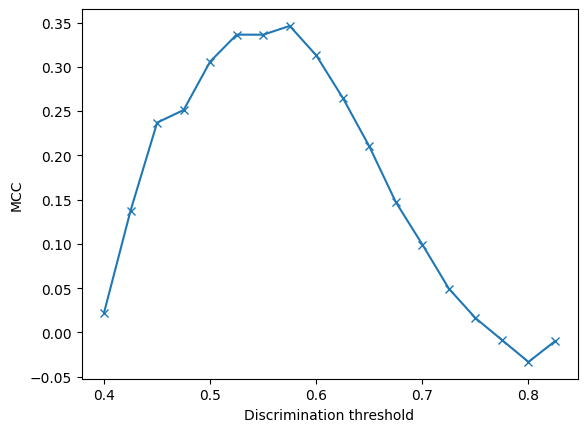

In [283]:
plt.plot(roc.discret_thr, roc.matthews, 'x-')
plt.xlabel('Discrimination threshold')
plt.ylabel('MCC')
plt.show()

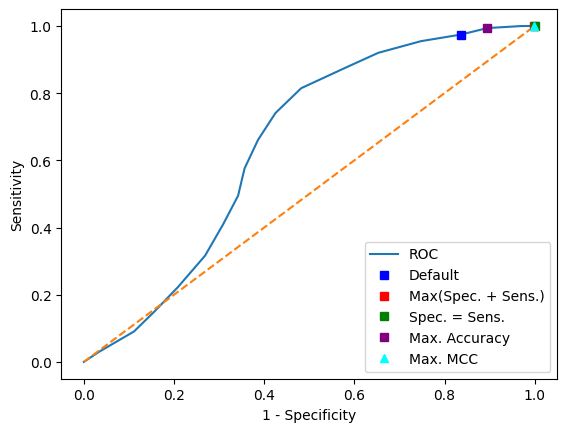

In [284]:
idx_maxacc = np.argmax(roc.accuracy)
idx_maxmcc = np.argmax(roc.matthews)

plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')

plt.plot(np.arange(0., 1., 0.01), 
         np.arange(0., 1., 0.01), 
         '--')

plt.plot(roc._specificity[idx_default_th], 
         roc.sensitivity[idx_default_th], 
         's', color = 'blue',
         label = 'Default')

plt.plot(roc._specificity[idx_youdensj], 
         roc.sensitivity[idx_youdensj], 
         's', color = 'red',
         label = 'Max(Spec. + Sens.)')

plt.plot(roc._specificity[idx_ballance], 
         roc.sensitivity[idx_ballance], 
         's', color = 'green', 
         label = 'Spec. = Sens.')

plt.plot(roc._specificity[idx_maxacc], 
         roc.sensitivity[idx_maxacc], 
         's', color = 'purple',
         label = 'Max. Accuracy')

plt.plot(roc._specificity[idx_maxmcc], 
         roc.sensitivity[idx_maxmcc], 
         '^', color = 'cyan', 
         label = 'Max. MCC')

plt.legend(loc = 4)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()


In [285]:
elevation_xa = pd.read_pickle("../data/elevation_xa.pkl")


elevation_df = elevation_xa.to_dataframe()
elevation_df = elevation_df.reset_index()
elevation_df['p'] = m.predict(elevation_df[["lat", "lon", "elevation"]])

elevation_df



,lat,lon,elevation,p
0,45.022917,-68.418750,86,0.064313
1,45.022917,-68.414583,87,0.064415
2,45.022917,-68.410417,88,0.064517
3,45.022917,-68.406250,93,0.064652
4,45.022917,-68.402083,95,0.064763
...,...,...,...,...
4090733,51.589583,-57.631250,219,0.991218
4090734,51.589583,-57.627083,219,0.991232
4090735,51.589583,-57.622917,211,0.991236
4090736,51.589583,-57.618750,207,0.991245


In [286]:
prob_array = elevation_df["p"].to_numpy()

In [287]:
prob_array = prob_array.reshape(elevation_xa.data.shape)

prob_xa = elevation_xa.copy()

prob_xa.data = prob_array

pd.to_pickle(prob_xa, "../data/prob_xa.pkl")

In [288]:
dir(prob_xa)


['T',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_layers__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__dask_tokenize__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '_

In [289]:
prob_xa.attrs

{'standard_name': 'height_above_mean_sea_level',
 'long_name': 'Elevation relative to sea level',
 'units': 'm',
 'grid_mapping': 'crs',
 'sdn_parameter_urn': 'SDN:P01::ALATZZ01',
 'sdn_parameter_name': 'Sea floor height (above mean sea level) {bathymetric height}',
 'sdn_uom_urn': 'SDN:P06::ULAA',
 'sdn_uom_name': 'Metres'}

In [290]:
prob_xa.attrs["long_name"] = "Probability of presence"
prob_xa.attrs["units"] = "p"

In [291]:
species_df = pd.read_pickle("../data/species_df.pkl")
species_code_lookup = pd.read_pickle("../data/species_code_lookup.pkl")

(45.6930833333333, 49.1464166666667)

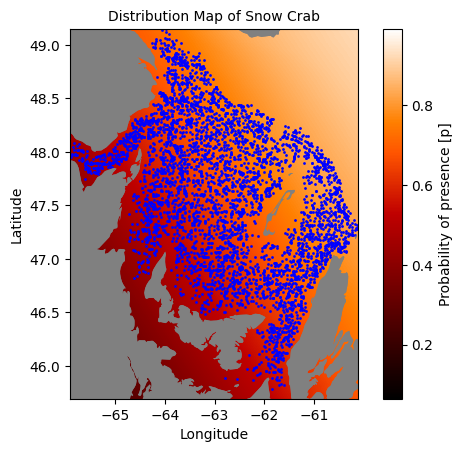

In [292]:
from geopandas import GeoDataFrame
from shapely import Point
import geopandas as gpd

fig, ax = plt.subplots()

prob_xa.plot(ax=ax, cmap="gist_heat")

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)
gdf = gdf.set_crs(epsg=4326)

    
pmask = gdf[species] == True
amask = gdf[species] == False
gdf[pmask].plot(ax=ax, marker="o", color='blue', markersize=1, label="present")
# gdf[amask].plot(ax=ax, marker="o", color='red', markersize=1, label="absent")



# this geojson is from here: https://open.canada.ca/data/en/dataset/85efc01b-163f-ebba-2378-c43eadfb3b3f
canada = gpd.read_file("../data/Canada_Provinical_boundaries_April2022_3931220444258526365.geojson")
# it is in a weird projection
canada = canada.to_crs(epsg=4326)
# create the figure and plot

# start by plotting the two geospatial dfs
# gdf.plot(ax=ax, color='red', markersize=2)
canada.plot(ax=ax, color='grey')

# set graph props
ax.set_title(f'Distribution Map of {species.title()}', fontsize=10)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')  
ax.set_xlim((np.min(df["longitude"]),np.max(df["longitude"])))
ax.set_ylim((np.min(df["latitude"]),np.max(df["latitude"])))
